In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graph_vis import draw_dot
import math

<h2>Differentiation</h2>
The derivative of a function ( f ) at a point ( x ) is defined as:

$$
f'(x) = \lim_{h \to 0} \frac{{f(x+h) -f(x)}}{h}
$$
provided this limit exists.

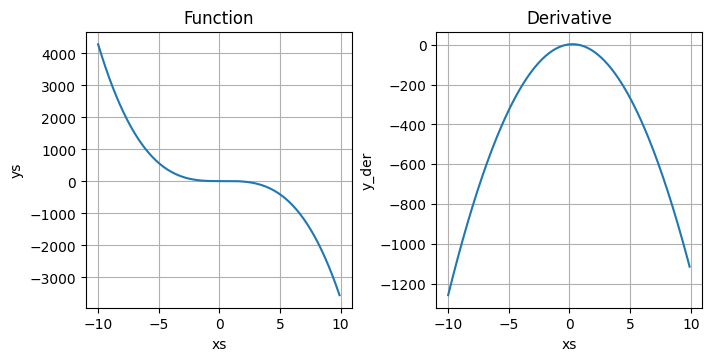

In [2]:
def f(x):
    return -4*x**3 + 3*x**2 + 2*x + 10

def derivate(x):
    return (f(x+0.00001) - f(x)) / 0.00001

xs = np.arange(-10, 10, 0.1)
ys = f(xs)

y_der = derivate(xs)

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), constrained_layout=True)

ax[0].plot(xs, ys)
ax[0].set_xlabel('xs')
ax[0].set_ylabel('ys')
ax[0].grid() 

ax[1].plot(xs, y_der)
ax[1].set_xlabel('xs')
ax[1].set_ylabel('y_der')
ax[1].grid()

ax[0].set_title('Function')
ax[1].set_title('Derivative')

plt.show()

In [33]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda : None 
        self.label = label
        self.grad = 0

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other): # Other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int or float)) # Only supporting for integers and floats
        out = Value(self.data**other, (self,), f"{other}")
        def _backward():
            self.grad += (other * (self.data**(other -1))) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1
    
    # def __rtruediv__(self, other): #
    #     return other * self**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), _op='tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad 
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [23]:
a = Value(2, label='a')
 
3*a 

Value(data=6)

<h3> Dummy neural net</h3>

In [24]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights W1, W2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias 
b = Value(6.8813735870195432, label='b')

x1w1 = x1.__mul__(w1); x1w1.label='x1*w1'
x2w2 = x2.__mul__(w2); x2w2.label='x2*w2'

x1w1_x2w2 = x1w1.__add__(x2w2); x1w1_x2w2.label='x1w1 + x2w2'

n = x1w1_x2w2.__add__(b); n.label='n'

o = n.tanh(); o.label='o'

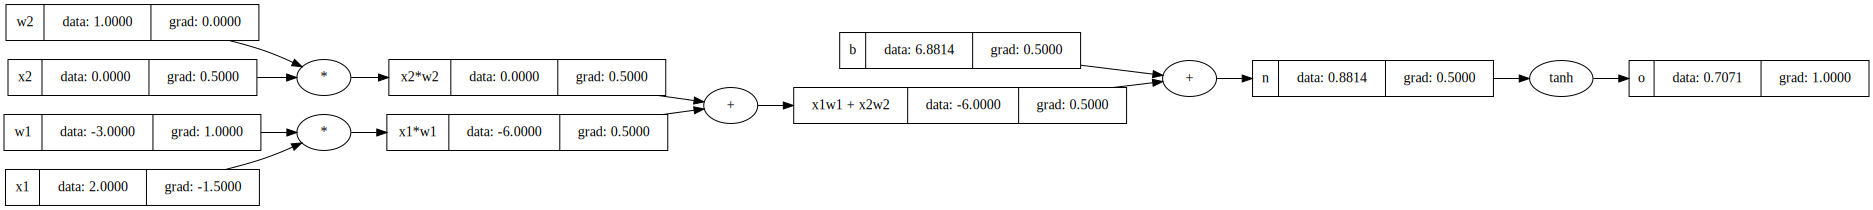

In [27]:
draw_dot(o)

In [26]:
o.backward()

In [15]:
# o.grad = 1
# o._backward()
# n._backward()
# b._backward()
# x1w1_x2w2._backward()
# x2w2._backward()
# x1w1._backward()
# x1._backward()
# w1._backward()
# x2._backward()
# w2._backward()

In [12]:
# # MANUAL BACKPROPAGATION

# o.grad = 1 # do/do = 1 Differ'n of 'o' w.r.to 'o' is 1.0
# n.grad = 1 - n.tanh().data**2 # o = tanh(n) --> do/dn = d(tanh(n))/ dn = 1 - tanh(n)**2
# b.grad = n.grad # do/db = do/dn * dn/db = n.grad * d( x1w1 + x2w2 + b )/ db = n.grad * 1 = n.grad
# x1w1_x2w2.grad = n.grad # do/d(x1w1_x2w2)=do/dn * dn/d(x1w1_x2w2)=n.grad * d ((x1w1+x2w2) + b)/d(x1w1+x2w2)=n.grad * 1 = n.grad
# x2w2.grad = x1w1_x2w2.grad
# x1w1.grad = x1w1_x2w2.grad

# # do / dw2 = do/dn * dn/d(x1w1_x2w2) * d(x1w1_x2w2)/d(x2w2) * d(x2w2) / dw2
# w2.grad = n.grad * 1 * 1 * x2.data  
# x2.grad = n.grad * 1 * 1 * w2.data

# w1.grad = n.grad * 1 * 1 * x1.data  
# x1.grad = n.grad * 1 * 1 * w1.data


In [34]:
a = Value(2)
b = Value(4)

a/b

Value(data=0.5)

In [35]:
4/a

TypeError: unsupported operand type(s) for /: 'int' and 'Value'